**Step 1: Import necessary packages!**

In [14]:
import os
import keras
import shutil
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

**Step 2: Listing the directories and doing some basic work to make it easy to work.**

In [6]:
# define the paths for the train and val folders
root_folder = "C:/Abhinav/Test/DL/Animal"
data_folder = "C:/Abhinav/Test\DL/Animal/data"
train_folder = "C:/Abhinav/Test/DL/Animal/train"
val_folder = "C:/Abhinav/Test\DL/Animal/val"

# get the list of sub directoriees (class folders) in the val folder
class_folders = [folder for folder in os.listdir(val_folder) if os.path.join(os.path.join(val_folder, folder))]

# move all files from val to train for each class
for class_folder in class_folders:
    val_class_path = os.path.join(val_folder, class_folder)
    train_class_path = os.path.join(train_folder, class_folder)
    
    # create the destination folder if it doesn't exist
    if not os.path.exists(train_class_path):
        os.makedirs(train_class_path)
        
    # get the list of files in the val class folder
    files_to_move = os.listdir(val_class_path)
    
    # move all files in the val class folder
    for file_name in files_to_move:
        src_path = os.path.join(val_class_path, file_name)
        dest_path = os.path.join(train_class_path, file_name)
        shutil.move(src_path, dest_path)

print("Files moved sucessfully.")

Files moved sucessfully.


In [8]:
# rename the folder
os.rename("C:/Abhinav/Test/DL/Animal/train", "C:/Abhinav/Test/DL/Animal/data")

# list all directories to check
directories = os.listdir(data_folder)
print(directories)
total_images = 0

# count images based on its category
for name in directories:
    path = os.path.join(data_folder, name)
    if os.path.isdir(path):
        print(f"Total {name} images: ", len(os.listdir(path)))
        total_images += len(os.listdir(path))
print("Total images: ", total_images)

['cat', 'dog', 'ELEPHANT', 'HORSE', 'LION']
Total cat images:  3037
Total dog images:  2927
Total ELEPHANT images:  3040
Total HORSE images:  3009
Total LION images:  2984
Total images:  14997


**Step 3: Splitting the dataset into training and testing.**

In [9]:
# set the train and test folders
new_train_folder = os.path.join(root_folder, 'train')
new_test_folder = os.path.join(root_folder, 'test')

# create train and test folders if they don't exist
os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(new_test_folder, exist_ok=True)

categories = os.listdir(data_folder)

# iterate over each category
for category in categories:
    # set the category folder paths
    category_data_folder = os.path.join(data_folder, category)
    category_new_train_folder = os.path.join(new_train_folder, category)
    category_new_test_folder = os.path.join(new_test_folder, category)
    
    # list all files in the category data folder
    all_files = os.listdir(category_data_folder)
    
    # split the dataset into train and test sets
    train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=14)
    
    # create train and test category folders
    os.makedirs(category_new_train_folder, exist_ok=True)
    os.makedirs(category_new_test_folder, exist_ok=True)
    
    # move files to the respective train and test category folders
    for file_name in train_files:
        source_path = os.path.join(category_data_folder, file_name)
        destination_path = os.path.join(category_new_train_folder, file_name)
        os.rename(source_path, destination_path)
        
    for file_name in test_files:
        source_path = os.path.join(category_data_folder, file_name)
        destination_path = os.path.join(category_new_test_folder, file_name)
        os.rename(source_path, destination_path)

print("Success! Split all the images.")

Success! Split all the images.


In [11]:
# get the count of train and test images
train_dir = os.path.join(root_folder, 'train')
test_dir = os.path.join(root_folder, 'test')

train_count = sum(len(os.listdir(os.path.join(train_dir, name))) for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name)))
test_count = sum(len(os.listdir(os.path.join(test_dir, name))) for name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, name)))

print("Total train images: ", train_count)
print("Total test images: ", test_count)
print("Total images: ", train_count+test_count)

Total train images:  11996
Total test images:  3001
Total images:  14997


**Step 4: Preparing the data for Training - Image Augmentation**

In [12]:
# augmented image
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 7,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)

test_generator = ImageDataGenerator(
    rescale=1./255
)
# Splitting
train_images = train_generator.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_images = train_generator.flow_from_directory(
    train_dir,
    target_size=(64,64),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# test_images = test_generator.flow_from_directory(
#     test_dir,
#     target_size=(64,64),
#     batch_size=1,
#     class_mode='categorical',
#     shuffle=False
# )

Found 9598 images belonging to 5 classes.
Found 2397 images belonging to 5 classes.


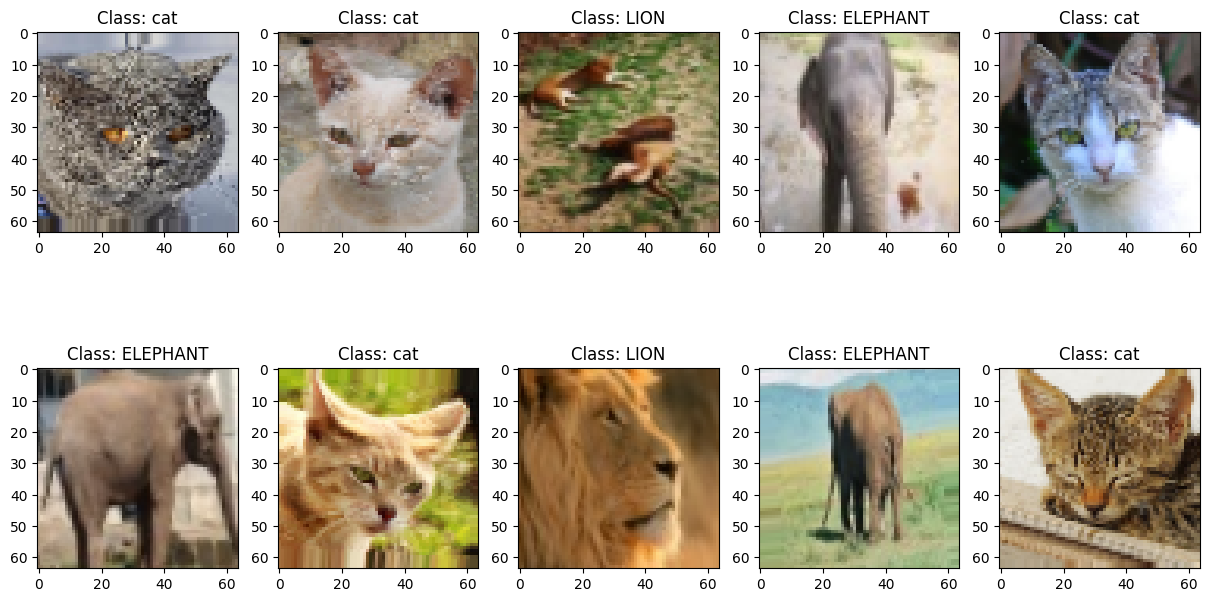

In [13]:
# Get a batch of images and labels
batch = next(train_images)

# Create the plot
plt.figure(figsize=(15, 8))

for i in range(10):
    # Create 10 subplots
    plt.subplot(2, 5, i+1)

    # Extract the image and one-hot encoded label
    image = batch[0][i]
    one_hot_encoded_label = batch[1][i]

    # Convert one-hot encoded label to class index
    class_index = np.argmax(one_hot_encoded_label)

    # Get the class label from the generator's class indices
    class_label = list(train_images.class_indices.keys())[class_index]

    # Display the image with the actual class label
    plt.imshow(image)
    plt.title(f'Class: {class_label}')

plt.show()

**Step 5: Building the CNN Model**

We will make a model with CNN architecture. To do that, we use Conv2D and MaxPoolig2D.
1. Layer 1: make Conv2D layer with 32 neurons, and 3x3 filters. Input shape for this layers based on pixel we've defined i.e. 64x64,w ith 3 channels.
2. Layer 2: x2 each Conv2D neurons, make it 4 layers. Each layer has regularizer, and we add batch normalization to prevent overfitting.
3. Dropout: To prevent overfitting.
4. Flatten the images(input) into 1-dimensional.
5. FC Layer 1: Hidden layers with 1024 neurons.
6. FC Layer 2-3: Hidden layers with 512, and 256 neurons (divided by 2).
7. Output layer: Output with 5 neurons, it'll return value to us, because we have 5 categories i.e. Elephant, Horse, Lion, cat, and dog.
8. We use Adam optimizers (very basic).
9. We use categorical cross entropy for loss (it's a very common loss function for classification of more rthan 2 categories.)

Additionally, we use callbacks to monitor the progress of the model training.

In [24]:
from keras.callbacks import TensorBoard
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    
    tf.keras.layers.Dense(5, activation='softmax')
])

class CustomAccuracyStop(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(CustomAccuracyStop, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') >= self.target_accuracy and logs.get('val_accuracy') >= self.target_accuracy:
                print(f"\nReached target accuracy of {self.target_accuracy}% on both training and validation. Stopping training.")
                self.model.stop_training = True

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint("mammal_classification.h5", monitor="val_accuracy", save_weights_only=False , save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor="val_loss", mode='min', min_delta=0.1, patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Determine Optimizer & Loss Function
model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                      

In [31]:
# plotting the model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# Start training
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[checkpoint, early_stopping, tensorboard_callback, reduce_lr, custom_accuracy_stop],
    verbose=1
)

Epoch 1/5
150/150 [==============================] - 71s 474ms/step - loss: 9.1109 - accuracy: 0.6712 - val_loss: 4.0683 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 2/5
150/150 [==============================] - 74s 496ms/step - loss: 1.9896 - accuracy: 0.7676 - val_loss: 2.8187 - val_accuracy: 0.2061 - lr: 0.0010
Epoch 3/5
150/150 [==============================] - 70s 465ms/step - loss: 1.2738 - accuracy: 0.7970 - val_loss: 2.0266 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 4/5
150/150 [==============================] - 70s 464ms/step - loss: 1.0756 - accuracy: 0.8104 - val_loss: 1.6114 - val_accuracy: 0.5561 - lr: 0.0010
Epoch 5/5
150/150 [==============================] - 67s 449ms/step - loss: 0.9908 - accuracy: 0.8207 - val_loss: 1.3358 - val_accuracy: 0.6767 - lr: 0.0010


In [32]:
# Get predictions for validation data
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)

# Get true labels
true_labels = np.argmax(val_labels, axis=1)  # Assuming val_labels are one-hot encoded

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, val_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
class_report = classification_report(true_labels, val_pred_labels)
print("Classification Report:")
print(class_report)


InvalidArgumentError: Graph execution error:

Detected at node sequential_3/layers_dense/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "C:\Users\abhin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\abhin\AppData\Local\Temp\ipykernel_7336\705799555.py", line 5, in <module>

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "c:\Users\abhin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [64,12288], In[1]: [784,512]
	 [[{{node sequential_3/layers_dense/Relu}}]] [Op:__inference_predict_function_108546]